<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/svm%3Dhog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [41]:
## Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/newmodidata/Y2022Ankle/normal"
ill_path = "/content/drive/MyDrive/newmodidata/Y2022Ankle/ill"

# Create lists to store HOG features and labels
hog_features = []
labels = []

# Function to apply HOG feature extraction
def apply_hog(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Modify HOG parameters as needed
    return hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(3, 3), visualize=False)

# Reading images from the normal directory
for files in os.listdir(normal_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(normal_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            hog_feature = apply_hog(image)
            hog_features.append(hog_feature)
            labels.append(0)  # Label for healthy images

# Reading images from the ill directory
for files in os.listdir(ill_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(ill_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            hog_feature = apply_hog(image)
            hog_features.append(hog_feature)
            labels.append(1)  # Label for ill images
# Convert the lists to NumPy arrays with dtype=object to handle varying feature lengths
hog_features = np.array(hog_features, dtype=object)
labels = np.array(labels)


In [42]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.1, random_state=42)

# Define hyperparameter grid for SVM
svm_param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 50, 70, 100],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [43]:
# Print the number of images used in the train and test datasets
print("Number of images in training dataset:", len(X_train))
print("Number of images in testing dataset:", len(X_test))

Number of images in training dataset: 160
Number of images in testing dataset: 18


In [44]:
# Create an SVM classifier with grid search
svm_classifier = GridSearchCV(SVC(), svm_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the SVM classifier on the training dataset
svm_classifier.fit(X_train, y_train)

# Predict on the testing dataset
y_test_pred = svm_classifier.predict(X_test)

# Generate classification report for the testing dataset
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for SVM on the testing dataset:\n", test_report)

Classification Report for SVM on the testing dataset:
               precision    recall  f1-score   support

           0       0.64      0.78      0.70         9
           1       0.71      0.56      0.63         9

    accuracy                           0.67        18
   macro avg       0.68      0.67      0.66        18
weighted avg       0.68      0.67      0.66        18



In [45]:
# Predict on the training dataset
y_train_pred = svm_classifier.predict(X_train)

# Generate classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for SVM on the training dataset:\n", train_report)


Classification Report for SVM on the training dataset:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        63

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



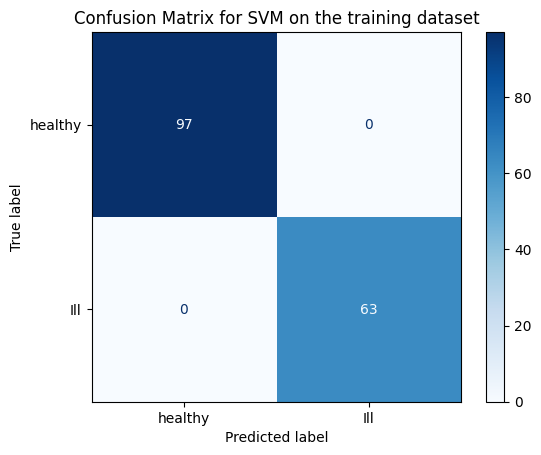

In [46]:
# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "Ill"])
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the training dataset")
plt.show()


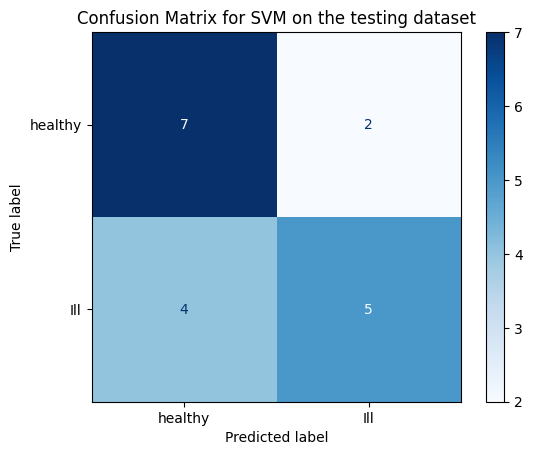

In [47]:
# Calculate the confusion matrix for the testing dataset
test_cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "Ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the testing dataset")
plt.show()


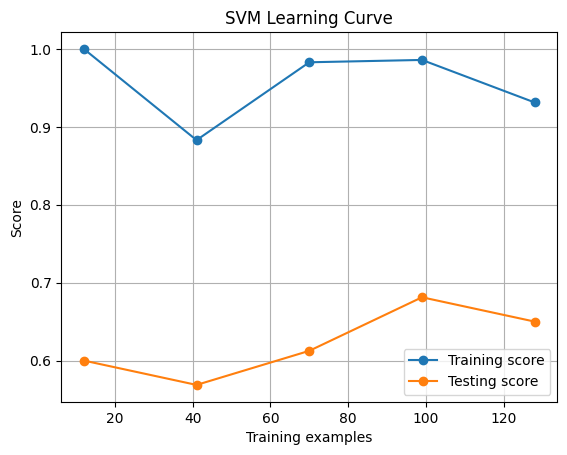

In [48]:
# Plot the learning curves
train_sizes, train_scores, test_scores = learning_curve(
    svm_classifier, X_train, y_train, cv=cv, train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.title("SVM Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Testing score")

plt.legend(loc="best")
plt.show()